In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import cv2
from PIL import Image
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Chargement des Données**

In [ ]:
dir = "./drive/MyDrive/ProjetStT/SignToText_Dataset/"

In [ ]:
df_train = pd.read_csv(dir+'sign_mnist_train.csv')
df_test = pd.read_csv(dir+'sign_mnist_test.csv')

**Affichage du dataframe**

In [ ]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


**Afficher la première image**

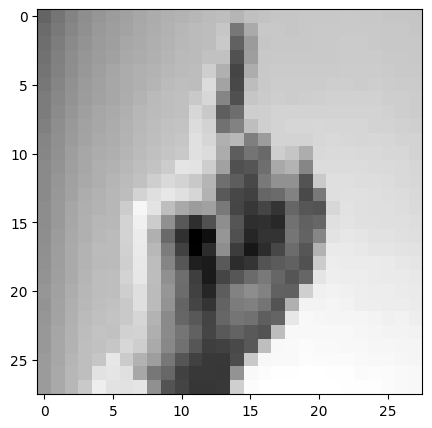

In [ ]:
# Exclure la colonne des labels
pixel_data_train = df_train.drop('label', axis=1)
pixel_data_test = df_test.drop('label', axis=1)
first_image = pixel_data_train.iloc[0].values.reshape(28, 28)

plt.figure(figsize=(10, 5))
plt.imshow(first_image, cmap='gray')
plt.show()

**Transformer le dataset en image/label**   
(au lieu de pixels/label)

In [ ]:
pixel_data_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
images_train = []
for i in range(len(pixel_data_train)):
  img = pixel_data_train.iloc[i].values.reshape(28, 28)
  images_train.append(img)

images_test = []
for i in range(len(pixel_data_test)):
  img = pixel_data_test.iloc[i].values.reshape(28, 28)
  images_test.append(img)

In [ ]:
df_train['image'] = images_train
df_test['image'] = images_test

In [ ]:
df_train = df_train.drop(df_train.columns[1:785], axis=1)
df_test = df_test.drop(df_test.columns[1:785], axis=1)
df_train.head()

,label,image
0,3,"[[107, 118, 127, 134, 139, 143, 146, 150, 153,..."
1,6,"[[155, 157, 156, 156, 156, 157, 156, 158, 158,..."
2,2,"[[187, 188, 188, 187, 187, 186, 187, 188, 187,..."
3,2,"[[211, 211, 212, 212, 211, 210, 211, 210, 210,..."
4,13,"[[164, 167, 170, 172, 176, 179, 180, 184, 185,..."


**Afficher les 10 premières images du dataset**

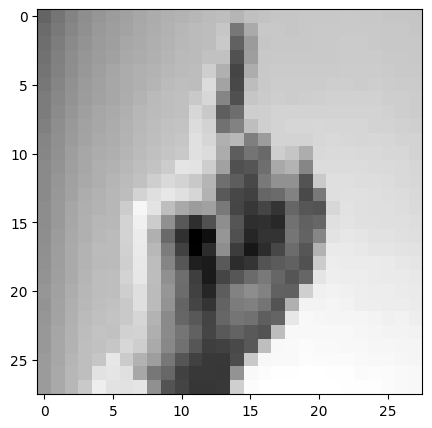

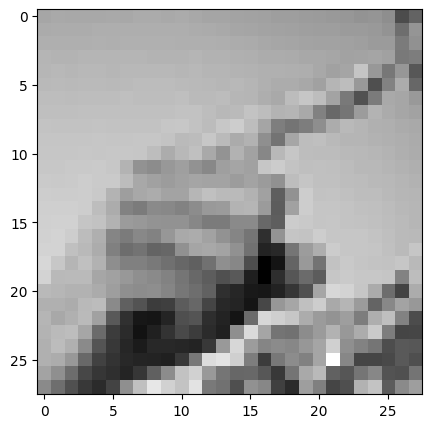

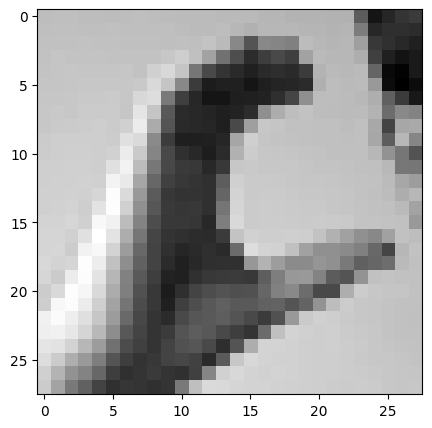

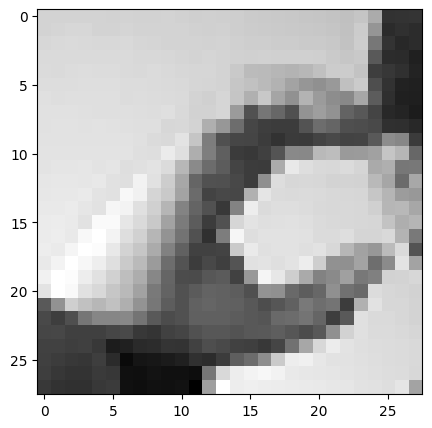

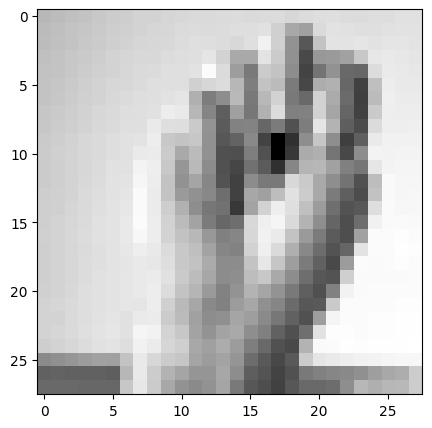

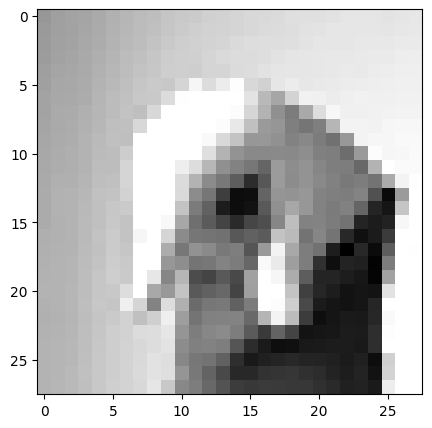

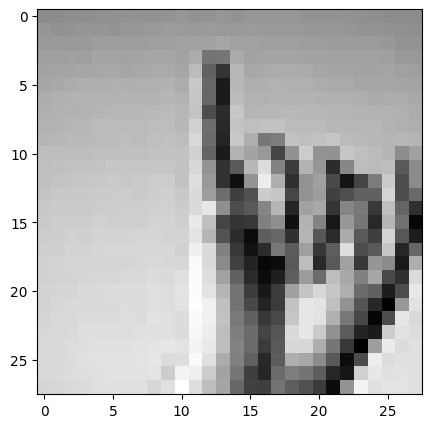

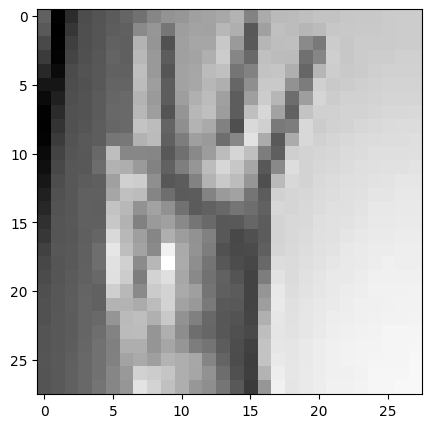

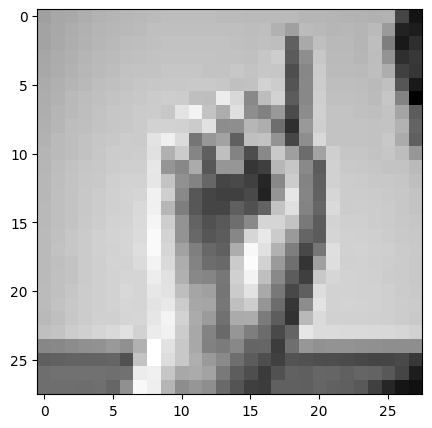

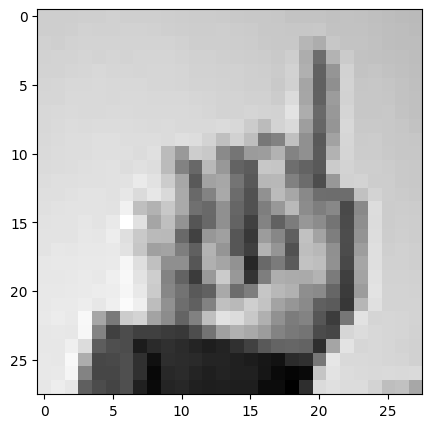

In [ ]:
for i in range(10):
  plt.figure(figsize=(10, 5))
  plt.imshow(df_train['image'][i], cmap='gray')
  plt.show()

**Determiner le nombre d'images par label**

In [ ]:
# On group le dataset par label
df = df_train.groupby(['label'],group_keys=True)

In [ ]:
lettres = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
count = [0] * len(lettres)

# Pour chacune des lettres on compte la longueur du dataset correspondant
for label, group in df:
  l = lettres[label[0]]
  count[lettres.index(l)] = len(group)

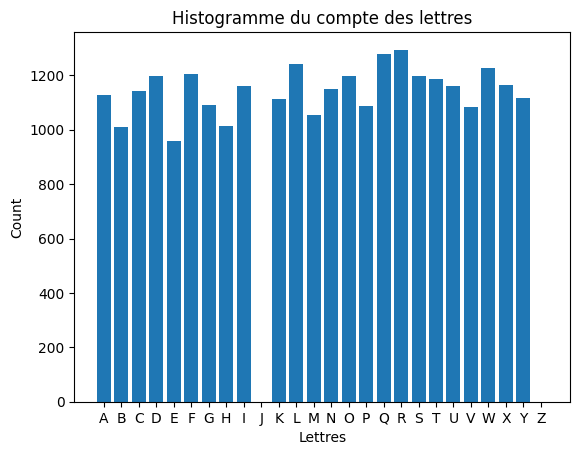

In [ ]:
# Affichage d'un histogramme qui montre la proportion de chaque lettre
plt.bar(lettres, count)
plt.xlabel('Lettres')
plt.ylabel('Count')
plt.title('Histogramme du compte des lettres')
plt.show()

On peut observer à travers l'histogramme que les données sont assez équilibrées, avec une moyenne d'environ 1100 images par étiquette. Il est intéressant de noter que les lettres J et Z ont un compte de 0, ce qui est conforme à la description du dataset indiquant l'absence des lettres J et Z.

Concernant les autres lettres, étant donné l'équilibre relatif des données, il semble inutile d'effectuer des ajustements de poids ou de recourir à des techniques d'Over/Under Sampling.

# **Préparation des données pour l'entrainement**

**Séparation des données en X et y**

In [ ]:
X_train = np.array([np.array(image).reshape(28, 28, 1) for image in df_train['image']])
y_train = np.array(df_train['label'])

X_test = np.array([np.array(image).reshape(28, 28, 1) for image in df_test['image']])
y_test = np.array(df_test['label'])

In [ ]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (27455, 28, 28, 1)
y_train shape: (27455,)
X_test shape: (7172, 28, 28, 1)
y_test shape: (7172,)


**Configuration de la classe ImageDataGenerator pour appliquer la Data Augmentation**

In [ ]:
# Configuration de la data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotation de l'image jusqu'à 20 degrés
    width_shift_range=0.2,  # Translation horizontale jusqu'à 20% de la largeur de l'image
    height_shift_range=0.2, # Translation verticale jusqu'à 20% de la hauteur de l'image
    shear_range=0.2,        # Cisaillement jusqu'à 20%
    zoom_range=0.2,         # Zoom avant/arrière jusqu'à 20%
    horizontal_flip=True,   # Inversion horizontale (très utile pour les images de mains)
    fill_mode='nearest'     # Stratégie de remplissage des pixels manquants
)

In [ ]:
print('Min label:', np.min(y_train))
print('Max label:', np.max(y_train))

Min label: 0
Max label: 24


In [ ]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

**Création du modèle CNN**

In [ ]:
# Création du modèle
model = Sequential()

model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy', tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 75)        750       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 75)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 75)        300       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 7, 7, 50)         

**Entrainement du modèle**

In [ ]:
cnn = model.fit(datagen.flow(X_train, y_train, batch_size=128), epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
215/215 [==============================] - 14s 48ms/step - loss: 2.3685 - accuracy: 0.2735 - recall_4: 0.0840 - val_loss: 1.3716 - val_accuracy: 0.5368 - val_recall_4: 0.2135
Epoch 2/30
215/215 [==============================] - 10s 48ms/step - loss: 1.2444 - accuracy: 0.5814 - recall_4: 0.4124 - val_loss: 1.0936 - val_accuracy: 0.6032 - val_recall_4: 0.4774
Epoch 3/30
215/215 [==============================] - 11s 51ms/step - loss: 0.7859 - accuracy: 0.7281 - recall_4: 0.6359 - val_loss: 0.4772 - val_accuracy: 0.8176 - val_recall_4: 0.7695
Epoch 4/30
215/215 [==============================] - 11s 51ms/step - loss: 0.5589 - accuracy: 0.8039 - recall_4: 0.7497 - val_loss: 0.6655 - val_accuracy: 0.7620 - val_recall_4: 0.7084
Epoch 5/30
215/215 [==============================] - 10s 47ms/step - loss: 0.4501 - accuracy: 0.8443 - recall_4: 0.8062 - val_loss: 0.9200 - val_accuracy: 0.7163 - val_recall_4: 0.6792
Epoch 6/30
215/215 [==============================] - 11s 50ms/step - 

In [ ]:
model.evaluate(X_test,y_test)

225/225 [==============================] - 1s 3ms/step - loss: 0.0379 - accuracy: 0.9845 - recall_4: 0.9841


[0.037868108600378036, 0.9845231175422668, 0.9841048717498779]

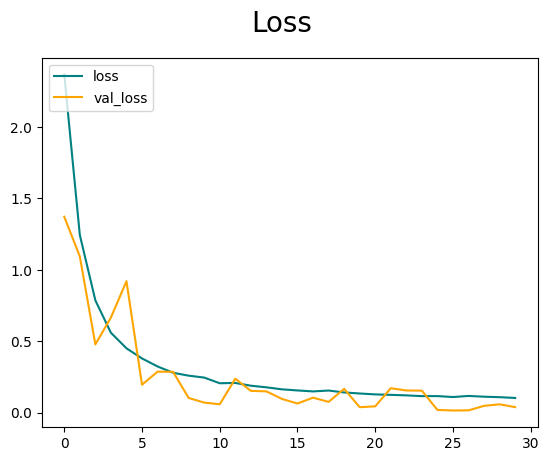

In [ ]:
fig = plt.figure()
plt.plot(cnn.history['loss'], color='teal', label='loss')
plt.plot(cnn.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

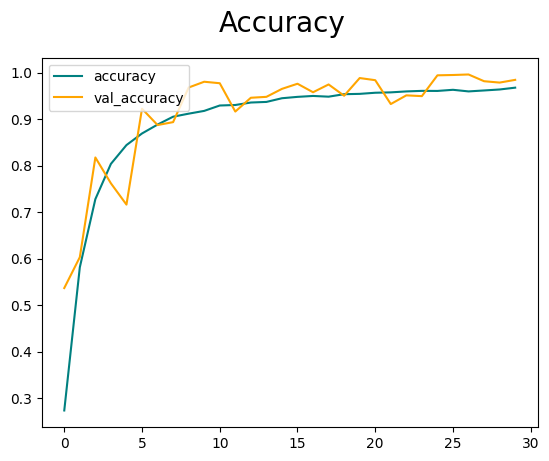

In [ ]:
fig = plt.figure()
plt.plot(cnn.history['accuracy'], color='teal', label='accuracy')
plt.plot(cnn.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
model_json = model.to_json()
with open("./drive/MyDrive/ProjetStT/model.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')
model.save_weights('./drive/MyDrive/ProjetStT/model.h5')
print('Weights saved')

Model Saved
Weights saved
